# Testing dropout

In [76]:
import warnings
warnings.filterwarnings("ignore")

import math
from scipy.special import logsumexp
import numpy as np

from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

import time


class net:

    def __init__(self, X_train, y_train, n_hidden, n_epochs = 40,
        normalize = False, tau = 1.0, dropout = 0.05):

        """
            Constructor for the class implementing a Bayesian neural network
            trained with the probabilistic back propagation method.
            @param X_train      Matrix with the features for the training data.
            @param y_train      Vector with the target variables for the
                                training data.
            @param n_hidden     Vector with the number of neurons for each
                                hidden layer.
            @param n_epochs     Numer of epochs for which to train the
                                network. The recommended value 40 should be
                                enough.
            @param normalize    Whether to normalize the input features. This
                                is recommended unles the input vector is for
                                example formed by binary features (a
                                fingerprint). In that case we do not recommend
                                to normalize the features.
            @param tau          Tau value used for regularization
            @param dropout      Dropout rate for all the dropout layers in the
                                network.
        """

        # We normalize the training data to have zero mean and unit standard
        # deviation in the training set if necessary

        if normalize:
            self.std_X_train = np.std(X_train, 0)
            self.std_X_train[ self.std_X_train == 0 ] = 1
            self.mean_X_train = np.mean(X_train, 0)
        else:
            self.std_X_train = np.ones(1)
            self.mean_X_train = np.zeros(1)

        X_train = (X_train - np.full(X_train.shape, self.mean_X_train)) / \
            np.full(X_train.shape, self.std_X_train)

        self.mean_y_train = np.mean(y_train)
        self.std_y_train = np.std(y_train)

        y_train_normalized = (y_train - self.mean_y_train) / self.std_y_train
        y_train_normalized = np.array(y_train_normalized, ndmin = 2).T
        
        # We construct the network
        N = X_train.shape[0]
        batch_size = 128
        lengthscale = 1e-2
        reg = lengthscale**2 * (1 - dropout) / (2. * N * tau)

        inputs = Input(shape=(1,))
        inter = Dropout(dropout)(inputs, training=True)
        inter = Dense(n_hidden, activation='relu', kernel_regularizer=keras.regularizers.l2(reg))(inter)
        for i in range(len(n_hidden) - 1):
            inter = Dropout(dropout)(inter, training=True)
            inter = Dense(n_hidden[i+1], activation='relu', kernel_regularizer=keras.regularizers.l2(reg))(inter)
        inter = Dropout(dropout)(inter, training=True)
        outputs = Dense(1, kernel_regularizer=keras.regularizers.l2(reg))(inter)
        model = Model(inputs, outputs)

        model.compile(loss='mean_squared_error', optimizer='adam')

        # We iterate the learning process
        start_time = time.time()
        model.fit(X_train, y_train_normalized, batch_size=batch_size, nb_epoch=n_epochs, verbose=0)
        self.model = model
        self.tau = tau
        self.running_time = time.time() - start_time

        # We are done!

    def predict(self, X_test, y_test):

        """
            Function for making predictions with the Bayesian neural network.
            @param X_test   The matrix of features for the test data
            
    
            @return m       The predictive mean for the test target variables.
            @return v       The predictive variance for the test target
                            variables.
            @return v_noise The estimated variance for the additive noise.
        """

        X_test = np.array(X_test, ndmin = 2)
        y_test = np.array(y_test, ndmin = 2).T

        # We normalize the test set

        X_test = (X_test - np.full(X_test.shape, self.mean_X_train)) / \
            np.full(X_test.shape, self.std_X_train)

        # We compute the predictive mean and variance for the target variables
        # of the test data

        model = self.model
        standard_pred = model.predict(X_test, batch_size=500, verbose=1)
        standard_pred = standard_pred * self.std_y_train + self.mean_y_train
        rmse_standard_pred = np.mean((y_test.squeeze() - standard_pred.squeeze())**2.)**0.5

        T = 10000
        
        Yt_hat = np.array([model.predict(X_test, batch_size=500, verbose=0) for _ in range(T)])
        Yt_hat = Yt_hat * self.std_y_train + self.mean_y_train
        MC_pred = np.mean(Yt_hat, 0)
        rmse = np.mean((y_test.squeeze() - MC_pred.squeeze())**2.)**0.5

        # We compute the test log-likelihood
        ll = (logsumexp(-0.5 * self.tau * (y_test[None] - Yt_hat)**2., 0) - np.log(T) 
            - 0.5*np.log(2*np.pi) + 0.5*np.log(self.tau))
        test_ll = np.mean(ll)

        # We are done!
        return rmse_standard_pred, rmse, test_ll

In [77]:
model = net(Xtrain, Ytrain, n_hidden = np.array([40]))

In [53]:
np.shape(Xtrain)

(100000,)

## Imports

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
#%matplotlib notebook
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras import losses
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import Sequential
import numpy
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.utils import normalize, to_categorical
from tensorflow import keras
from tensorflow.keras import layers
import os

print(tf.__version__)
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

/Users/laurens/opt/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/laurens/opt/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/laurens/opt/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/lauren

2.0.0-beta1


This script aims to analyze the effectiveness of using MCdropout in order to capture epistemic uncertainty. With this I mean a combination of both model uncertainty and model misspecification. I also estimate the aleatoric uncertainty (inherit noise) and try to analyze epistemic uncertainty of this estimation.

## Generating data manually

Instead of using a dataset I generate my own data so that I can know exactly what the noise and underlying functions are. I took the function $y=2x^{2}+3x$ and added a normally distributed noise term with mean 0 and $\sigma=0.1+0.3x^{2}$.

In [3]:
const=0.3
def y(x):
    return 2*x**2+3*x

def sigma(x):
    return 0.1+const*x**2

negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [61]:
N = 100000  #I generate 100.000 datapoint
Xtrain=np.array(np.linspace(-2,2,N)) #In the interval [-2,2]
Ytrain=np.zeros(N)
real=np.zeros(N)
for i in range(0,N):
    Ytrain[i]=y(Xtrain[i])+np.random.normal(0,sigma(Xtrain[i]))
    real[i]=y(Xtrain[i])

In [80]:
Xtest=np.linspace(-2,2,333) #I make a test X set
np.shape(Xtest)

(333,)

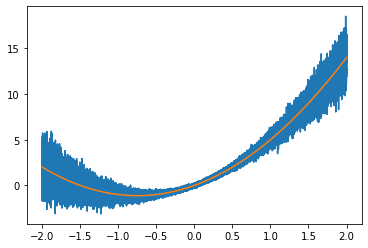

In [55]:
plt.plot(Xtrain,Ytrain)
plt.plot(Xtrain,real)
plt.show()

## Making a dropout model

I have made a model with 3 hidden layers outputting to a distribution layer. Before every activation function (except the final one) I have placed a dropout layer. I used the functional API to enable dropout during testing and to have more flexibility than when simply using a sequential API.

In [20]:
inputs = tf.keras.Input(shape=1)
c1= layers.Dense(200)(inputs)
a1=tf.keras.layers.ELU(alpha=1.0)(c1)
d1=layers.Dropout(0.1)(a1,training=True)
c2= layers.Dense(200)(d1)
a2=tf.keras.layers.ELU(alpha=1.0)(c2)
d2=layers.Dropout(0.1)(a2,training=True)
c3=layers.Dense(2)(d2)
d3=layers.Dropout(0.0)(c3,training=True) #There is a dropout layer but it is turned of!
o=tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:])))(d3) #The scale is stdev!!
#outputs=layers.Activation('softmax')(c2)
modeld2= tf.keras.Model(inputs, o)
modeld2.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 500)               1000      
_________________________________________________________________
elu_12 (ELU)                 (None, 500)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 500)               0         
_________________________________________________________________
elu_13 (ELU)                 (None, 500)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 501 

In [21]:
modeld2.compile(
    loss = 'mse',
    optimizer=tf.optimizers.Adam(learning_rate=0.05)
)

In [22]:
modeld2.fit(
  Xtrain, Ytrain,
  epochs=20, validation_split = 0.2, verbose=1,shuffle=True,batch_size=5000)

Train on 80000 samples, validate on 20000 samples
Epoch 1/20
80000/80000 [==============================] - 0s 6us/sample - loss: 5.2330 - val_loss: 87.4836
Epoch 2/20
80000/80000 [==============================] - 0s 4us/sample - loss: 4.4087 - val_loss: 79.9795
Epoch 3/20
80000/80000 [==============================] - 0s 4us/sample - loss: 4.2718 - val_loss: 83.8765
Epoch 4/20
80000/80000 [==============================] - 0s 4us/sample - loss: 4.2438 - val_loss: 81.4934
Epoch 5/20
80000/80000 [==============================] - 0s 4us/sample - loss: 4.2381 - val_loss: 85.4520
Epoch 6/20
80000/80000 [==============================] - 0s 4us/sample - loss: 4.2468 - val_loss: 79.7162
Epoch 7/20
80000/80000 [==============================] - 0s 4us/sample - loss: 4.2385 - val_loss: 81.1253
Epoch 8/20
80000/80000 [==============================] - 0s 4us/sample - loss: 4.2286 - val_loss: 82.9583
Epoch 9/20
80000/80000 [==============================] - 0s 4us/sample - loss: 4.2287 - val_l

At testing I do not actually want the entire distribution returned but rather the parameters of the distribution ($\mu$ and $\sigma$). In order to have this I create a new model that copies all the layers of the previous layer up intil the penultimate one.

In [8]:
modeld3=tf.keras.Model(inputs, c3)

In [9]:
meanstd=[]
D=1000
Xtest=np.linspace(-2,2,333) #I make a test X set
Ytest=y(Xtest)  #And calculate the corresponding y's without noise
for i in range(0,D):
    l=modeld3.predict(Xtest)
    l[:,1]=1e-3 + tf.math.softplus(0.05 * l[:,1])
    meanstd.append(l)
meanss=np.mean(meanstd,axis=0) #Mean of means and stddevs
stdvs= np.std(meanstd,axis=0)

In [10]:
sigmatest=np.zeros(len(Xtest))
for i in range(0,len(Xtest)):
    sigmatest[i]=sigma(Xtest[i])

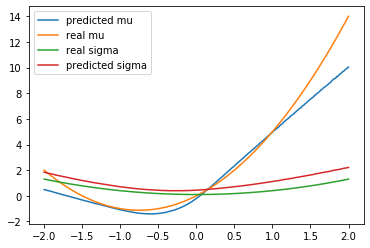

In [11]:
plt.plot(Xtest,meanss[:,0],label='predicted mu')
plt.plot(Xtest,Ytest, label='real mu')
plt.plot(Xtest,sigmatest,label='real sigma')
plt.plot(Xtest,meanss[:,1] ,label='predicted sigma')
plt.legend()
plt.show()

In [13]:
N=500
testvalue=-1
Xnew=np.full((N,), testvalue)

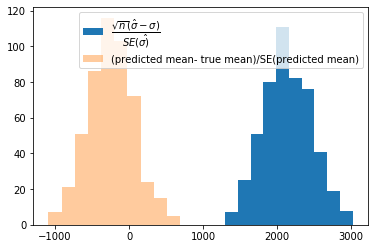

mean1= 2139.916 std1= 324.1118 mean2= -242.74532 std2= 311.65842


In [25]:
Z1=np.sqrt(N)*(1e-3 + tf.math.softplus(0.05 * modeld3.predict(Xnew)[:,1])-sigma(Xnew))/np.std(1e-3 + tf.math.softplus(0.05 * modeld3.predict(Xnew)[:,1]))
Z2=np.sqrt(N)*(modeld3.predict(Xnew)[:,0]-y(testvalue))/np.std(modeld3.predict(Xnew)[:,0])
plt.hist(Z1,label='$\dfrac{\sqrt{n}({\hat{\sigma}} -  \sigma)}{SE(\hat{\sigma)}}$')
plt.hist(Z2,alpha=0.4,label='(predicted mean- true mean)/SE(predicted mean)')
plt.legend()
plt.show()
print("mean1=",np.mean(Z1),'std1=',np.std(Z1),'mean2=',np.mean(Z2),'std2=',np.std(Z2))

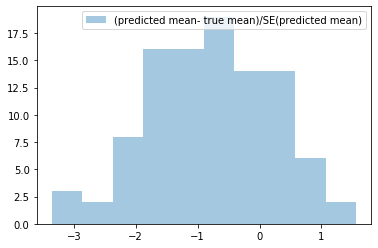

In [29]:
M=100
Z=np.zeros(M)
for i in range(0,M):
    N=50
    testvalue=1
    Xnew=np.full((N,), testvalue)
    Z[i]=np.sqrt(N)*(np.mean(modeld3.predict(Xnew)[:,0])-np.mean(y(testvalue)))/np.std(modeld3.predict(Xnew)[:,0])
plt.hist(Z,alpha=0.4,label='(predicted mean- true mean)/SE(predicted mean)')
plt.legend()
plt.show()

## A simpeler version.

In [54]:
inputs = tf.keras.Input(shape=1)
c1= layers.Dense(50)(inputs)
d1=layers.Dropout(0.3)(c1,training=True)
a1=tf.keras.layers.ELU(alpha=1.0)(d1)
c2= layers.Dense(30)(a1)
d2=layers.Dropout(0.3)(c2,training=True)
a2=tf.keras.layers.ELU(alpha=1.0)(d2)
c3=layers.Dense(1)(a2)

model4= tf.keras.Model(inputs, c3)
model4.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 50)                100       
_________________________________________________________________
dropout_19 (Dropout)         (None, 50)                0         
_________________________________________________________________
elu_14 (ELU)                 (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 30)                1530      
_________________________________________________________________
dropout_20 (Dropout)         (None, 30)                0         
_________________________________________________________________
elu_15 (ELU)                 (None, 30)                0  

In [55]:
model4.compile(
    loss='mse',
    optimizer=tf.optimizers.Adam(learning_rate=0.05)
)

In [57]:
model4.fit(
  Xtrain, Ytrain,
  epochs=20, validation_split = 0.1, verbose=1,shuffle=True,batch_size=10000)

Train on 90000 samples, validate on 10000 samples
Epoch 1/20
90000/90000 [==============================] - 0s 1us/sample - loss: 0.6682 - val_loss: 6.6738
Epoch 2/20
90000/90000 [==============================] - 0s 1us/sample - loss: 0.6617 - val_loss: 6.2127
Epoch 3/20
90000/90000 [==============================] - 0s 1us/sample - loss: 0.6627 - val_loss: 5.5398
Epoch 4/20
90000/90000 [==============================] - 0s 1us/sample - loss: 0.6656 - val_loss: 5.4824
Epoch 5/20
90000/90000 [==============================] - 0s 1us/sample - loss: 0.6413 - val_loss: 5.8487
Epoch 6/20
90000/90000 [==============================] - 0s 1us/sample - loss: 0.6379 - val_loss: 5.7607
Epoch 7/20
90000/90000 [==============================] - 0s 1us/sample - loss: 0.6283 - val_loss: 5.2915
Epoch 8/20
90000/90000 [==============================] - 0s 1us/sample - loss: 0.6464 - val_loss: 5.7235
Epoch 9/20
90000/90000 [==============================] - 0s 1us/sample - loss: 0.6363 - val_loss: 5.1

In [61]:
N=1000 #Number of different Xi
D=100 #number of dropout samples for every Xi
Z=np.zeros(N)
sigmas=np.zeros(N)
testvalues=np.linspace(-1.0,1.0,N)
count1=0 
count2=0
for i in range(0,N):
    testvalue=testvalues[i]
    Xnew=np.full((D,), testvalue)
    Z[i]=(np.mean(model4.predict(Xnew)[:,0])-y(testvalue))/np.std(model4.predict(Xnew)[:,0])
    sigmas[i]=np.std(model4.predict(Xnew)[:,0])
    m=np.mean(model4.predict(Xnew)[:,0])
    s=np.std(model4.predict(Xnew)[:,0])
    t=y(testvalue)
    if (t<(m+s) and t>(m-s)):
        count1=count1+1
    if (t<(m+2*s) and t>(m-2*s)):
        count2=count2+1
    
print(count1/N) #The fraction of the real means in the interval predicted mean +/- std(predicted mean)
print(count2/N) #The fraction of the real means in the interval predcited mean +/- std(predicted mean)
#plt.hist(Z,label='(predicted mean- true mean)/SE(predicted mean)')
#plt.legend()
#plt.show()
#print("mean=",np.mean(Z),'std=',np.std(Z))

0.916
1.0


$\frac{\hat{\mu}-\mu}{\sqrt{\mathbb V(\hat{y_{i}})}}$

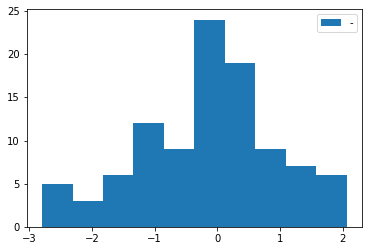

mean= -0.16288824 std= 1.0973864


In [63]:

testvalue=1.2
testvalue=testvalues[i]
Xnew=np.full((100,), testvalue)
Z=(model4.predict(Xnew)[:,0]-np.mean(model4.predict(Xnew)[:,0]))/np.std(model4.predict(Xnew)[:,0])
plt.hist(Z,label='-')
plt.legend()
plt.show()
print("mean=",np.mean(Z),'std=',np.std(Z))

$\frac{\hat{y_{i}}-\bar{\hat{y_{i}}}}{\sqrt{\mathbb V(\hat{y_{i}})}}$

In [64]:
meanvar=[]
D=1000
Xtest=np.linspace(-2,2,333)
Ytest=y(Xtest)
for i in range(0,D):
    l=model4.predict(Xtest)
    meanvar.append(l)
meanss=np.mean(meanvar,axis=0) #Mean of means and variances)
varss=np.var(meanvar,axis=0)

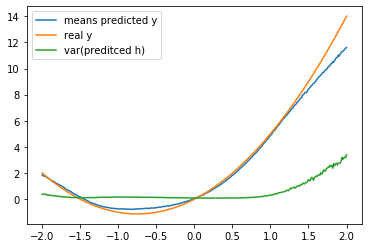

In [66]:
plt.plot(Xtest,meanss[:,0],label='means predicted y')
plt.plot(Xtest,Ytest, label='real y')
plt.plot(Xtest,varss,label='var(predicted h)')
plt.legend()
plt.show()

In [105]:
np.std(modeld3.predict(Xnew)[:,0])

0.14368644

In [109]:
np.mean((modeld3.predict(Xnew)[:,0]))

-0.571699